In [1]:
import keras
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import glob
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2
%matplotlib inline

In [2]:
# Image Config
HEIGHT = 320
WIDTH = 320
NUM_CLASSES = 1

# Training Config
BATCH_SIZE = 32
EPOCHS =50
LEARNING_RATE = 3e-3
AUTOTUNE = tf.data.AUTOTUNE

In [3]:
def load_image(filepath:str):
    img = Image.open(filepath)
    img = img.resize((HEIGHT,WIDTH))
    img = np.array(img)
    img=np.cast['float32'](img)
    img = img/255
    return img
def load_mask(filepath:str):
    img = Image.open(filepath)
    img = img.resize((HEIGHT,WIDTH))
    img = np.array(img)
    img=np.cast['float32'](img)
    img = img/255
    return img

In [4]:
filelist_trainx =(glob.glob('inputx/*.jpg'))
train_images = np.array([load_image(fname) for fname in filelist_trainx])
filelist_trainy =(glob.glob('inputy/*.png'))
masks = np.array([load_mask(fname) for fname in filelist_trainy])

Text(0.5, 1.0, 'Original Mask')

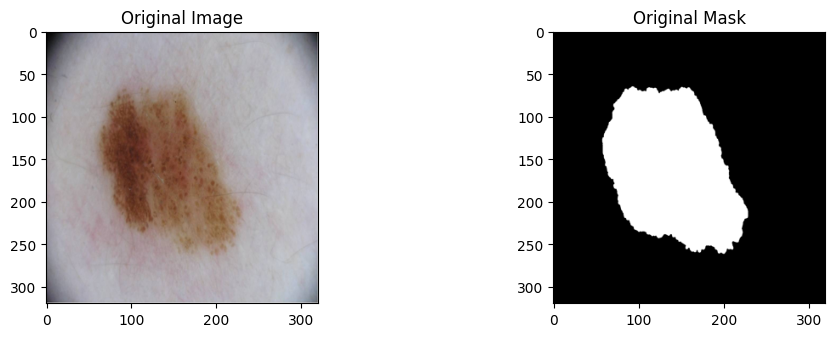

In [83]:
img_num = 7
plt.figure(figsize=(12,12))
plt.subplot(3,2,1)
plt.imshow(train_images[img_num])
plt.title('Original Image')
plt.subplot(3,2,2)
plt.imshow(masks[img_num], plt.cm.binary_r)
plt.title('Original Mask')


In [84]:
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return x_image, y_image.astype('int')

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')
def img_augmentation(x_train, y_train):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    for idx in range(len(x_train)):
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        x,y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)
    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

In [85]:
x_rotat, y_rotat, x_flip, y_flip = img_augmentation(train_images, masks)

In [86]:
train_images = np.concatenate((train_images, x_rotat, x_flip))
masks = np.concatenate((masks, y_rotat, y_flip))

In [10]:
dataset = tf.data.Dataset.from_tensor_slices((train_images, masks))

# Get the number of elements in the dataset
num_elements = len(train_images)

# Define the size of the training set
train_size = int(0.8 * num_elements)

# Define the size of the testing set
test_size = num_elements - train_size

# Split the dataset into training and testing sets
train_dataset = dataset.take(test_size)
test_dataset = dataset.take(test_size)
train_data=train_dataset.batch(BATCH_SIZE)
test_data=test_dataset.batch(BATCH_SIZE)

In [98]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [99]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = keras.layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = keras.layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.UpSampling2D(2)(x)

        # Project residual
        residual = keras.layers.UpSampling2D(2)(previous_block_activation)
        residual = keras.layers.Conv2D(filters, 1, padding="same")(residual)
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = keras.layers.Conv2D(num_classes, 3, activation="sigmoid", padding="same")(
        x
    )
    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [7]:
import keras.backend as K
def jaccard_distance(y_true, y_pred, smooth=100):
    y_true = tf.cast(y_true, tf.float32)
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac)

def dice_coef(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    dice = (2 * intersection + smooth) / (sum_ + smooth)
    return dice

def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true)*(1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives/(possible_negatives+K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true*y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives/(possible_positives+K.epsilon())

In [101]:
# Build model
model = get_model(img_size=(HEIGHT, WIDTH), num_classes=NUM_CLASSES)
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 320, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_108 (Conv2D)            (None, 160, 160, 32  896         ['input_13[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_180 (Batch  (None, 160, 160, 32  128        ['conv2d_108[0][0]']             
 Normalization)                 )                                                          

# Run the saved model on a few test images

In [8]:
model = tf.keras.models.load_model('./model',custom_objects = {'jaccard_distance': jaccard_distance, 'dice_coef': dice_coef, 'accuracy': accuracy, 'specificity': specificity, 'sensitivity': sensitivity})

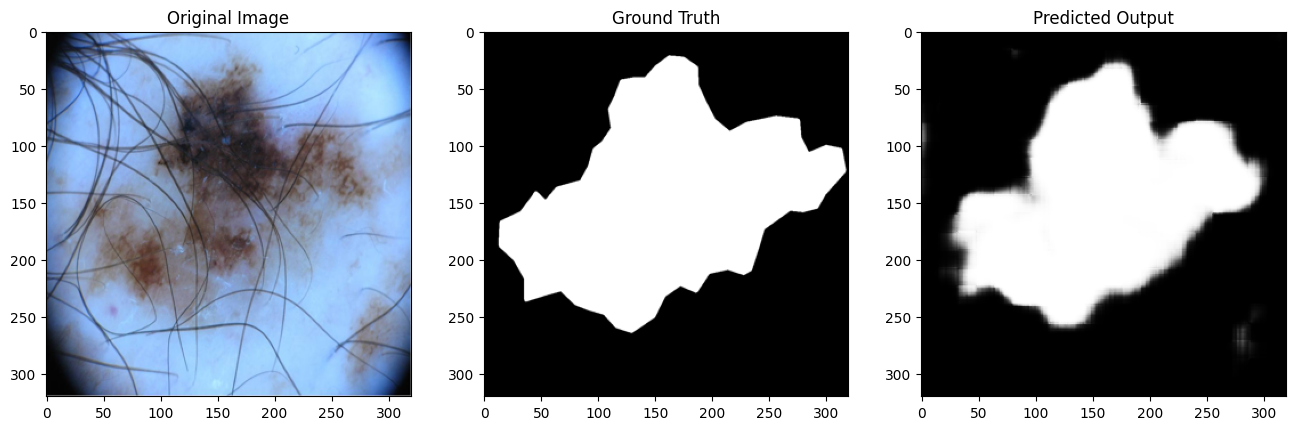

In [14]:
img_num = 49
img_pred = model.predict(train_images[img_num].reshape(1,320,320,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(train_images[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(masks[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(320, 320), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()